In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..

/Users/cheriehe/OneDrive - Business/kaggle202/earthquake prediction


In [3]:
%cd ..

/Users/cheriehe/OneDrive - Business/kaggle202


In [4]:
scaled_test_X=pd.read_csv('test_features.csv')

scaled_train_X=pd.read_csv('train_features.csv')

train_y=pd.read_csv('y_features.csv')

In [5]:
scaled_test_X.shape

(2624, 831)

In [6]:
scaled_test_X.head()

,Hann_window_mean_150,Hann_window_mean_1500,Hann_window_mean_15000,Hann_window_mean_50,Hilbert_mean,abs_max,abs_max_roll_mean_10,abs_max_roll_mean_100,abs_max_roll_mean_1000,abs_max_roll_mean_10000,...,std_roll_std_10000,std_roll_std_50,std_roll_std_500,sum,time_rev_asym_stat_1,time_rev_asym_stat_10,time_rev_asym_stat_100,time_rev_asym_stat_5,time_rev_asym_stat_50,trend
0,4.491140,4.484860,4.426717,4.491630,6.703153,115.0,91.6,10.42,5.495,4.8284,...,1.524127,2.862491,2.609314,673767.0,-0.052494,24.461415,-24.696669,2.838643,-2.437498,-2.476946e-07
1,4.170633,4.165608,4.111654,4.170983,6.833615,152.0,99.3,11.90,5.009,4.4692,...,2.364856,4.175896,3.931232,625673.0,0.588375,185.380124,-12.056081,56.675625,53.214837,2.009021e-06
2,4.609608,4.603891,4.544624,4.610042,7.180588,248.0,209.1,19.11,6.234,4.9169,...,4.033028,5.534443,5.308515,691539.0,1.517607,416.757088,-32.027690,143.248043,-2.538065,3.577592e-07
3,4.530821,4.524946,4.466192,4.531238,6.079078,93.0,62.1,9.18,5.446,4.8740,...,1.320629,2.477723,2.286835,679721.0,0.051814,0.705854,15.880020,3.613541,-8.094229,-1.825526e-07
4,4.127661,4.121530,4.061062,4.128137,6.618645,177.0,107.7,14.13,5.027,4.4925,...,2.706260,4.178636,3.946117,619251.0,-0.643042,136.725937,56.830895,-23.090826,-1.608672,-1.556475e-06


In [7]:
import sklearn.model_selection as gs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold
from itertools import product,chain

In [8]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [9]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', loss_function='MAE')
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=[], use_best_model=True, verbose=False)
    oof[val_idx] = model.predict(X_val)
    y_pred_valid = model.predict(X_val)
    predictions += model.predict(scaled_test_X) / folds.n_splits
    score = mean_absolute_error(y_val, y_pred_valid)
    print (score)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_columns
    fold_importance_df["importance"] = model.get_feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model
    gc.collect()
print('Full mae %.6f' % mean_absolute_error(train_y, oof))

fold 0
2.0773915016836697
fold 1
2.049280707003823
fold 2
2.0287058227111516
fold 3
1.9835571490640038
fold 4
2.085261811700466
Full mae 2.044839


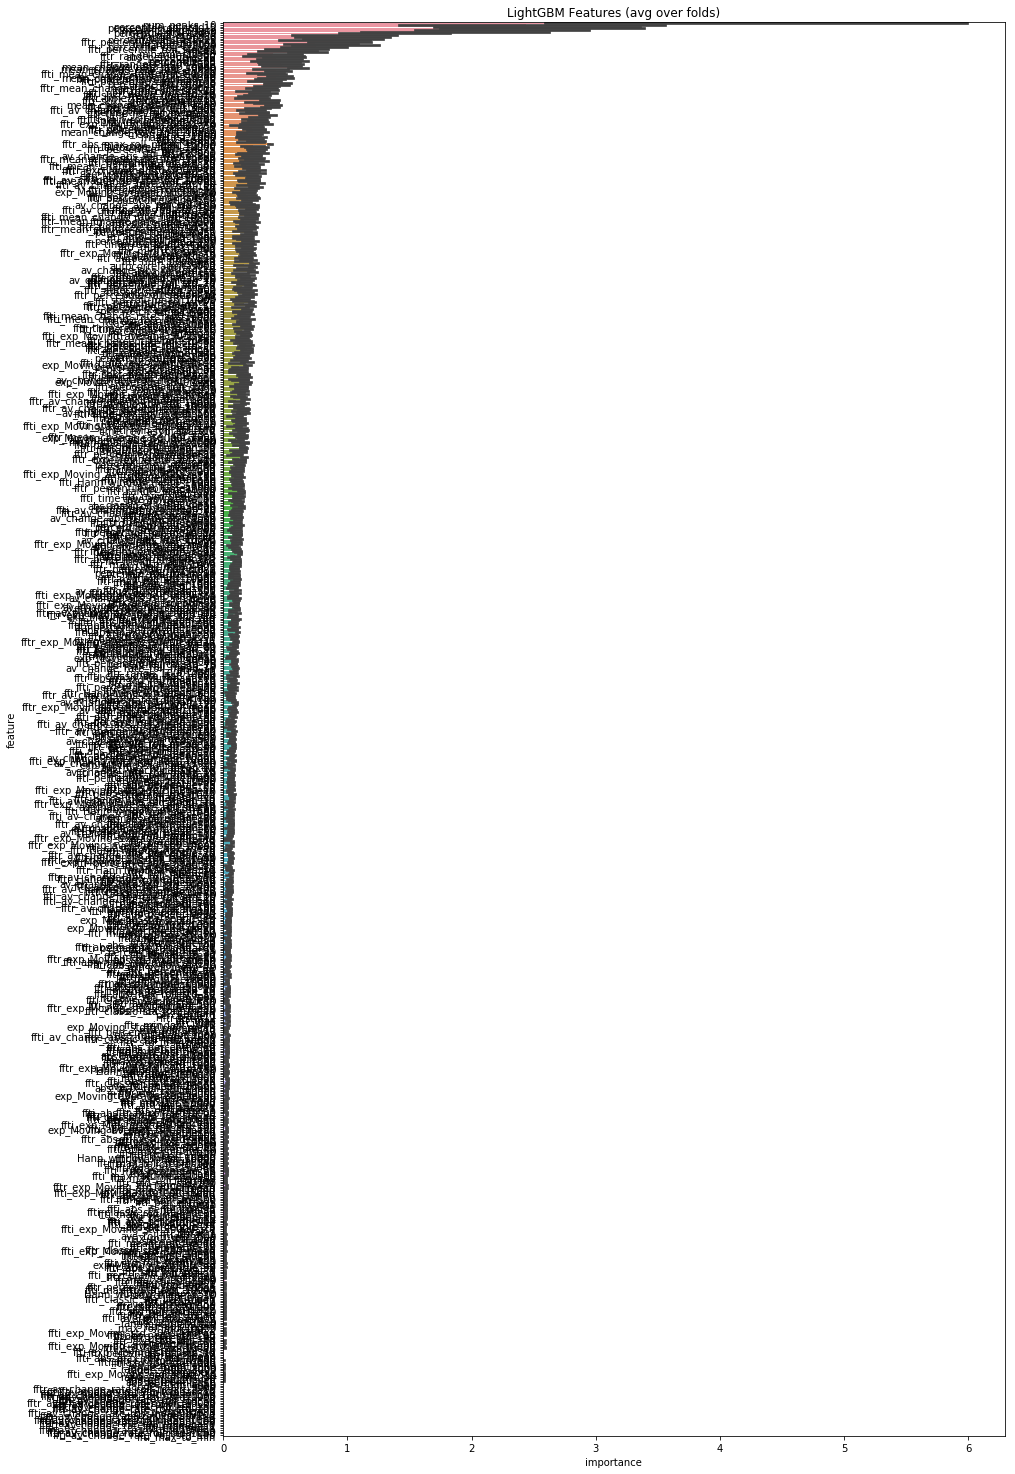

In [10]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.show()

In [11]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.time_to_failure = predictions
submission.to_csv('submission_cat.csv',index=True)

In [12]:
len(train_columns)

831

In [17]:
len(model.get_feature_importance())

NameError: name 'model' is not defined

In [20]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', loss_function='MAE', 
                             depth=2, l2_leaf_reg=100, border_count=10 )
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=[], use_best_model=True, verbose=False)
    oof[val_idx] = model.predict(X_val)
    y_pred_valid = model.predict(X_val)
    predictions += model.predict(scaled_test_X) / folds.n_splits
    score = mean_absolute_error(y_val, y_pred_valid)
    print(score)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_tr.columns.values
    fold_importance_df["importance"] = model.get_feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model
    gc.collect()
print('Full mae %.6f' % mean_absolute_error(train_y, oof))

fold 0
2.0953440059495163
fold 1
2.0604465676795543
fold 2
2.0241793153509278
fold 3
1.9917734600996104
fold 4
2.061066437807046
Full mae 2.046562


In [21]:
print('Full mae %.6f' % mean_absolute_error(train_y, oof))

Full mae 2.046562


In [22]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.time_to_failure = predictions
submission.to_csv('submission_cat3.csv',index=True)

In [23]:
top_cols = list( feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:100].index)

In [24]:
# Taking less columns 
scaled_train_X = scaled_train_X[top_cols]
scaled_test_X = scaled_test_X[top_cols]

In [25]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [28]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', loss_function='MAE', 
                             depth=2, l2_leaf_reg=100, border_count=10 )
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=[], use_best_model=True, verbose=False)
    oof[val_idx] = model.predict(X_val)
    y_pred_valid = model.predict(X_val)
    predictions += model.predict(scaled_test_X) / folds.n_splits
    score = mean_absolute_error(y_val, y_pred_valid)
    print(score)
    del model
    gc.collect()
print('Full mae %.6f' % mean_absolute_error(train_y, oof))

fold 0
2.0700607838101597
fold 1
2.026627468899563
fold 2
2.0129281527577065
fold 3
1.9645600569912884
fold 4
2.0283421282725262
Full mae 2.020504


In [27]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.time_to_failure = predictions
submission.to_csv('submission_cat4.csv',index=True)

In [31]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', loss_function='MAE')
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=[], use_best_model=True, verbose=False)
    oof[val_idx] = model.predict(X_val)
    y_pred_valid = model.predict(X_val)
    predictions += model.predict(scaled_test_X) / folds.n_splits
    score = mean_absolute_error(y_val, y_pred_valid)
    print(score)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_columns
    fold_importance_df["importance"] = model.get_feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model
    gc.collect()
print('Full mae %.6f' % mean_absolute_error(train_y, oof))

fold 0
2.0516779151533
fold 1
2.0042131215166816
fold 2
2.0049602174740047
fold 3
1.950821424037753
fold 4
2.0686055390468177
Full mae 2.016056


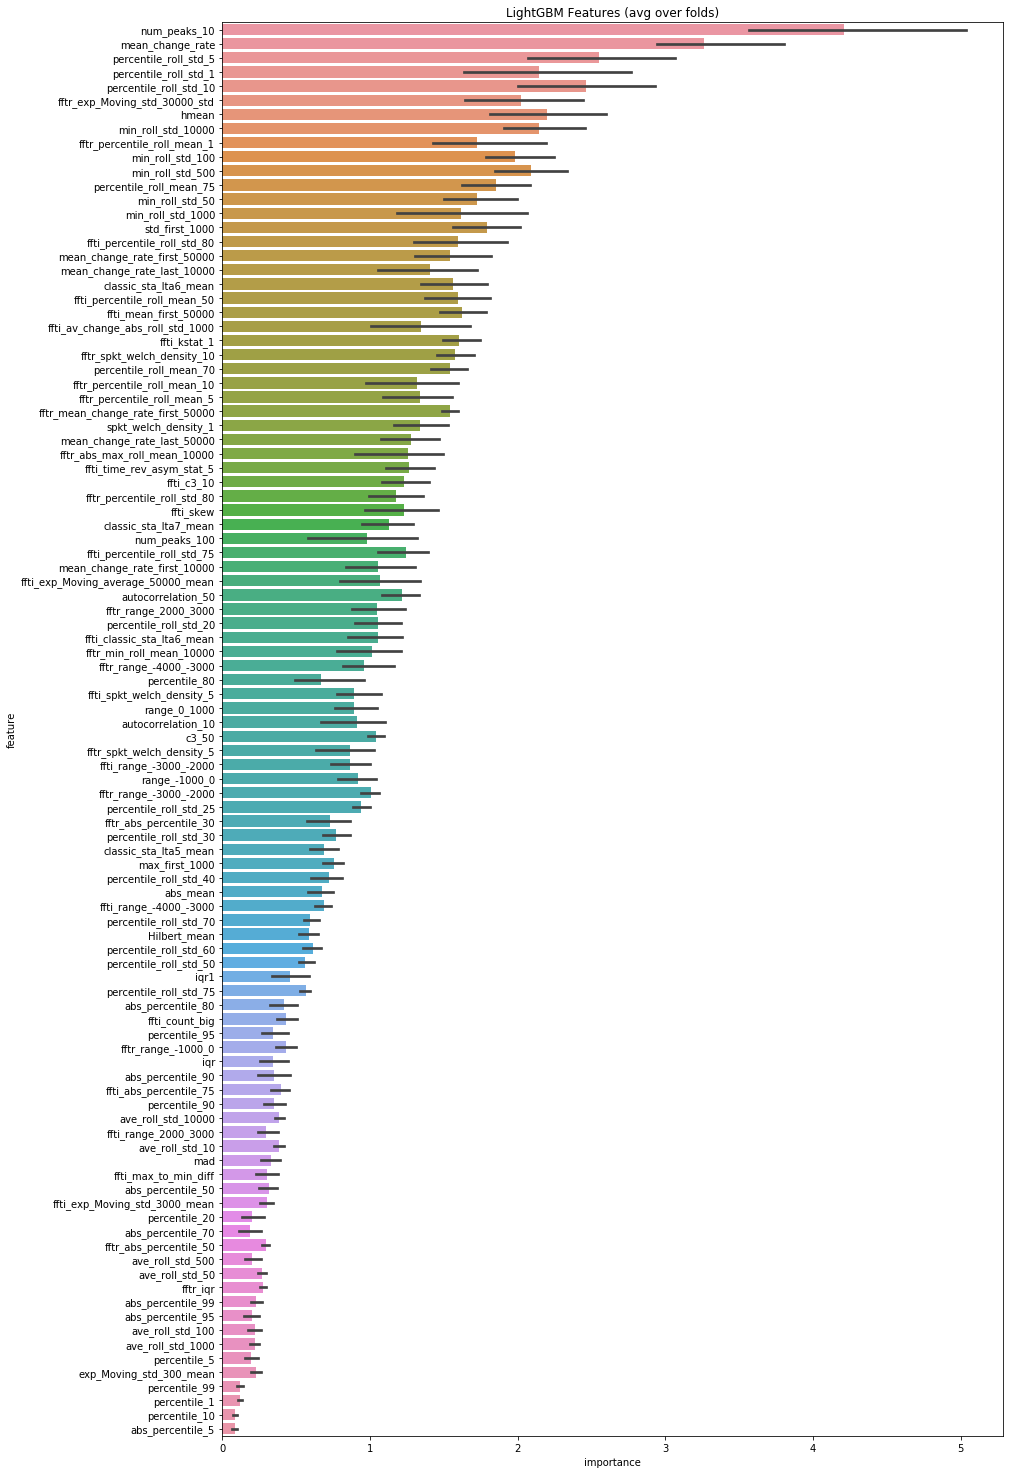

In [32]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.show()

In [33]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.time_to_failure = predictions
submission.to_csv('submission_cat2.csv',index=True)